<a href="https://colab.research.google.com/github/riyabhatnagar021/Cat-dog_classifier_using_VGG16/blob/master/cat_dog_classifier_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
# print(os.listdir("../input"))

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [0]:
import zipfile
zer=zipfile.ZipFile('drive/My Drive/GG.zip','r')
zer.extractall()
zer.close()

In [0]:
filenames = os.listdir("GG/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
#     print(category)
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
(df['category']).value_counts()

1    4000
0    4000
Name: category, dtype: int64

FINE TUNING


In [0]:
from keras import applications
input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)
pre_train_model=applications.VGG16(input_shape=input_shape,include_top=False,weights='imagenet')
for layer in pre_train_model.layers[:15]:
  layer.trainable=False
last_layer=pre_train_model.get_layer('block5_pool')
last_output=last_layer.output

In [0]:
last_output.shape[1:]

TensorShape([Dimension(4), Dimension(4), Dimension(512)])

In [0]:
from keras.models import Sequential
from keras.layers import Dense,GlobalAveragePooling2D,Flatten

In [0]:
top_model=Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=pre_train_model.output_shape[1:]))
top_model.add(Dense(512,activation='relu'))
top_model.add(Dense(1,activation='sigmoid'))

top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 263,169
Trainable params: 263,169
Non-trainable params: 0
_________________________________________________________________


In [0]:
model=Sequential()
model.add(pre_train_model)
model.add(top_model)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 263169    
Total params: 14,977,857
Trainable params: 7,342,593
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
from keras import optimizers

In [0]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.SGD(lr=1e-4,momentum=0.9),metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 263169    
Total params: 14,977,857
Trainable params: 7,342,593
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 


In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "GG/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 6400 validated image filenames belonging to 2 classes.


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "GG/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


In [0]:
epochs=3 if FAST_RUN else 20
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
#     callbacks=callbacks
)

Epoch 1/20
400/400 [==============================] - 46s 116ms/step - loss: 0.1760 - acc: 0.9295 - val_loss: 0.1530 - val_acc: 0.9419
Epoch 2/20
400/400 [==============================] - 46s 114ms/step - loss: 0.1715 - acc: 0.9291 - val_loss: 0.1776 - val_acc: 0.9319
Epoch 3/20
400/400 [==============================] - 45s 113ms/step - loss: 0.1639 - acc: 0.9328 - val_loss: 0.1844 - val_acc: 0.9306
Epoch 4/20
400/400 [==============================] - 48s 121ms/step - loss: 0.1588 - acc: 0.9327 - val_loss: 0.1571 - val_acc: 0.9413
Epoch 5/20
400/400 [==============================] - 48s 120ms/step - loss: 0.1571 - acc: 0.9377 - val_loss: 0.1562 - val_acc: 0.9425
Epoch 6/20
400/400 [==============================] - 51s 127ms/step - loss: 0.1596 - acc: 0.9372 - val_loss: 0.1493 - val_acc: 0.9431
Epoch 7/20
400/400 [==============================] - 45s 113ms/step - loss: 0.1431 - acc: 0.9444 - val_loss: 0.1705 - val_acc: 0.9363
Epoch 8/20
400/400 [==============================] - 4

[[0.26502323]]


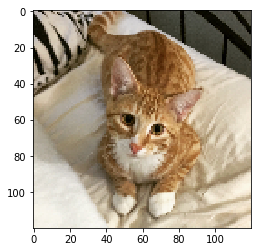

In [0]:
import cv2
def prepare(filepath):
  
  img_size=150
  img_array=cv2.imread(filepath,cv2.IMREAD_COLOR)
  
  new_array=cv2.resize(img_array,(IMAGE_HEIGHT,IMAGE_WIDTH))
  
  we=new_array.reshape(-1,IMAGE_HEIGHT,IMAGE_WIDTH,3)
  
  
  return we

my_img='catte.jpg'
prediction=model.predict([prepare(my_img)])

img = image.load_img(my_img, target_size=(120, 120))
plt.imshow(img)
print(prediction)

if(prediction<=0.5):
  print('Its a cat')
else:
  print('Its a dog')
